In [99]:
from torch.nn import Sequential
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os

In [104]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Data loading

In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# batch_size = 4
batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size,
    shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size*2,
                                         shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## DATA EXPLORATION TODO

## Logistic Regression

### Data processing

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
LR_train_x, LR_train_y = trainset.data.reshape(50000,-1), trainset.targets
LR_test_x, LR_test_y = testset.data.reshape(10000,-1),testset.targets
# LR_train_x,LR_val_x,LR_train_y,LR_val_y = train_test_split(LR_train_x,LR_train_y,test_size=0.2,random_state=42)

In [59]:
LR_train_x.shape

(40000, 3072)

### Straightforward logistic regression without any modification

In [ ]:
LogReg = LogisticRegression()
LogReg.fit(LR_train_x,LR_train_y)
logreg_score = LogReg.score(LR_test_x,LR_test_y)


Increasing number of iterations

In [60]:
LogReg = LogisticRegression(max_iter=1000,solver='saga',random_state=42)
LogReg.fit(LR_train_x,LR_train_y)
logreg_score = LogReg.score(LR_test_x,LR_test_y)

Spoiler: it takes forever


### Downscaling images first

In [ ]:
factor = 2 # scaling factor
LR_train_x_rescaled = trainset.data[:,::factor,::factor,].reshape(50000,-1)
LR_test_x_rescaled = testset.data[:,::factor,::factor,].reshape(10000,-1)
# LR_test_x_rescaled.shape
LogReg = LogisticRegression(solver='saga')
LogReg.fit(LR_train_x_rescaled,LR_train_y)
logreg_score = LogReg.score(LR_test_x_rescaled,LR_test_y)

ConvergenceWarning: The max_iter was reached which means the coef_ did not converge   
  "the coef_ did not converge", ConvergenceWarning)   
0.4037

### PCA before logistic regression

In [17]:
from sklearn.decomposition import PCA
factor = 2 # scaling factor
LR_train_x_PCA = trainset.data[:,::factor,::factor,].reshape(50000,-1)
LR_test_x_PCA = testset.data[:,::factor,::factor,].reshape(10000,-1)
n_components = 3*32 #
pca = PCA(n_components=n_components)
LR_train_x_PCA = pca.fit_transform(LR_train_x_PCA)
LR_test_x_PCA = pca.transform(LR_test_x_PCA)

In [18]:
LogReg = LogisticRegression(solver='saga')
LogReg.fit(LR_train_x_PCA,LR_train_y)
logreg_score = LogReg.score(LR_test_x_PCA,LR_test_y)
print(logreg_score)

0.3926


### PCA with downscaled images

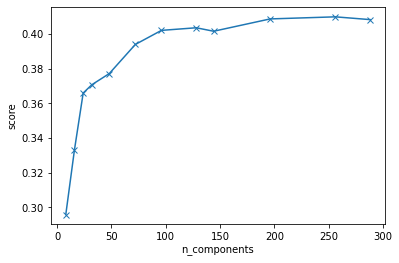

In [44]:
def logreg(factor,n_components):
    LR_train_x_PCA = (trainset.data[:,::factor,::factor,]/255).reshape(50000,-1)
    LR_test_x_PCA = (testset.data[:,::factor,::factor,]/255).reshape(10000,-1)
    # n_components = 3*32 #
    pca = PCA(n_components=n_components)
    LR_train_x_PCA = pca.fit_transform(LR_train_x_PCA)
    LR_test_x_PCA = pca.transform(LR_test_x_PCA)

    LogReg = LogisticRegression(solver='saga')
    LogReg.fit(LR_train_x_PCA,LR_train_y)
    logreg_score = LogReg.score(LR_test_x_PCA,LR_test_y)
    return logreg_score


scores =[]
n_list = [8,16,24,32,48,72,96,128,144,196,256,288] #logistic regression does not converge fast enough for values larger than 300
for n in n_list :
    scores.append(logreg(factor=1,n_components=n))

plt.figure("score for logreg")
plt.plot(n_list,scores,"-x")
plt.ylabel("score")
plt.xlabel("n_components")
plt.show()


### PCA with grayscale or only 1 channel

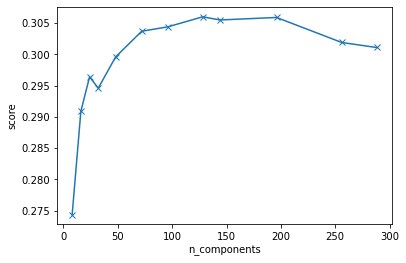

In [40]:
def logreg_grayscale(n_components):
    LR_train_x_grayscale = (trainset.data[:,:,:,:3] @ [0.3,0.6,0.1] / 255).reshape(50000,-1)
    LR_test_x_grayscale = (testset.data[:,:,:,:3] @ [0.3,0.6,0.1] / 255).reshape(10000,-1)
    pca = PCA(n_components=n_components)
    LR_train_x_PCA = pca.fit_transform(LR_train_x_grayscale)
    LR_test_x_PCA = pca.transform(LR_test_x_grayscale)

    LogReg = LogisticRegression(solver='saga')
    LogReg.fit(LR_train_x_PCA,LR_train_y)
    logreg_score = LogReg.score(LR_test_x_PCA,LR_test_y)
    return logreg_score

scores =[]
n_list = [8,16,24,32,48,72,96,128,144,196,256,288] #logistic regression does not converge fast enough for values larger than 300
for n in n_list :
    scores.append(logreg_grayscale(n_components=n))

plt.figure("score for logreg grayscaled")
plt.plot(n_list,scores,"-x")
plt.ylabel("score")
plt.xlabel("n_components")
plt.show()


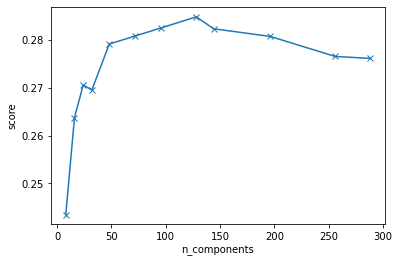

In [43]:
def logreg_single_channel(n_components,channel):
    LR_train_x_channel = (trainset.data[:,:,:,channel] / 255).reshape(50000,-1)
    LR_test_x_channel = (testset.data[:,:,:,channel] /255).reshape(10000,-1)
    pca = PCA(n_components=n_components)
    LR_train_x_PCA = pca.fit_transform(LR_train_x_channel)
    LR_test_x_PCA = pca.transform(LR_test_x_channel)

    LogReg = LogisticRegression(solver='saga')
    LogReg.fit(LR_train_x_PCA,LR_train_y)
    logreg_score = LogReg.score(LR_test_x_PCA,LR_test_y)
    return logreg_score

scores =[]
n_list = [8,16,24,32,48,72,96,128,144,196,256,288] #logistic regression does not converge fast enough for values larger than 300
for n in n_list :
    scores.append(logreg_single_channel(n_components=n,channel=0))

plt.figure(f"score for logreg with only 1 channel")
plt.plot(n_list,scores,"-x")
plt.ylabel("score")
plt.xlabel("n_components")
plt.show()


### Final logistic regression iteration

Grayscale and single channel loses a lot of information, so we'll ignore them. PCA gives the best result around n_components = 256. Downscaling obviously destroys information even before PCA, so we'll be using factor = 1. Using seaborn library lets display confusion matrix.


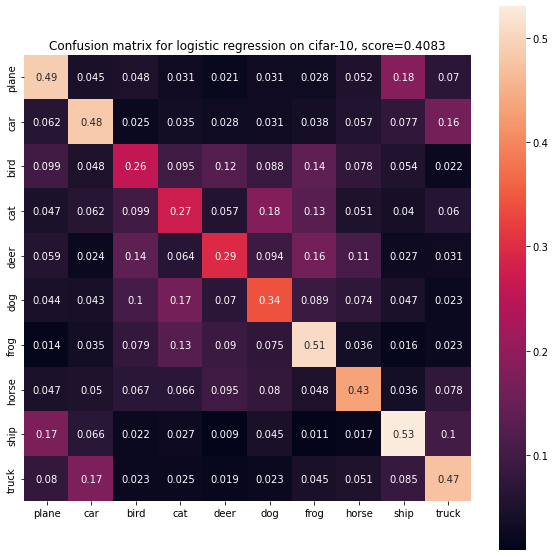

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#small modification to logreg()
def logreg(factor=1,n_components=256):
    LR_train_x_PCA = (trainset.data[:,::factor,::factor,]/255).reshape(50000,-1)
    LR_test_x_PCA = (testset.data[:,::factor,::factor,]/255).reshape(10000,-1)
    # n_components = 3*32 #
    pca = PCA(n_components=n_components)
    LR_train_x_PCA = pca.fit_transform(LR_train_x_PCA)
    LR_test_x_PCA = pca.transform(LR_test_x_PCA)

    LogReg = LogisticRegression(solver='saga')
    LogReg.fit(LR_train_x_PCA,LR_train_y)
    logreg_score = LogReg.score(LR_test_x_PCA,LR_test_y)
    predictions = LogReg.predict(LR_test_x_PCA)
    return logreg_score,predictions

score, y_pred = logreg(factor=1,n_components=256)
cf_matrix = confusion_matrix(LR_test_y,y_pred)
# sns.heatmap(cf_matrix/1000,annot=True,xticklabels=classes,yticklabels=classes)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cf_matrix/1000,annot=True,xticklabels=classes,yticklabels=classes,ax=ax,square=True)
ax.set_title(f"Confusion matrix for logistic regression on cifar-10, score={score}")
plt.show()

It seems like Logistic Regression has a problem differentiating animals from one another. Overall vehicles such as planes, trucks, cars and ships have the best scores, but they still have a noticable overlap. 

## Neural Networks
first we create the classes for some architectures

### CNN, architecture 0


In [18]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.network = Sequential(
        nn.Conv2d(3, 48, 3,2,1),
        nn.ReLU(),
        nn.LocalResponseNorm(3),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(48, 96,3,2,1),
        nn.ReLU(),
        nn.LocalResponseNorm(1),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(96,128,3,2,1),
        nn.ReLU(),
        nn.Conv2d(128,128,3,2,1),
        nn.ReLU(),
        nn.Conv2d(128,96,3,2,1),
        nn.ReLU(),
        nn.LocalResponseNorm(1),#* mmaybe remove these rows
        nn.ReLU(),              #*
        nn.Flatten(),
        nn.Linear(96 , 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
        )
    def forward(self,x):
        return self.network(x)


### CNN1, architecture 1 

In [17]:
class CNN1(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.network = Sequential(
            nn.Conv2d(3,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),
            nn.Dropout(p=0.25),

            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
            nn.Dropout(p=0.25),

            nn.Flatten(),
            nn.Linear(128*8*8,512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512,10)
        )
    def forward(self,x):
        return self.network(x)

### CNN2, architecture 2

In [5]:
class CNN2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
    def forward(self,x):
        return self.network(x)

### CNN3, architecture 3

In [47]:
class CNN3(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(), 
            nn.Linear(128*2*2, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Softmax(1),
        )
    def forward(self,x):
        return self.network(x)

### Define a function for easier training and validating

In [8]:
@torch.no_grad()
def validation_step(model: nn.Module, batch,device):
    model.eval()
    images,labels = batch[0].to(device), batch[1].to(device)
    outputs = model(images)
    loss = F.cross_entropy(outputs,labels)
    _, predicted = torch.max(outputs.data,1)
    acc = torch.tensor(torch.sum(predicted == labels).item() / len(predicted))
    return {'val_loss': loss.detach(), 'val_acc' : acc}


In [65]:
def fit(model : nn.Module,train_loader,test_loader,lr = 0.001,beta=(0.9,0.999),eps=1e-8,
epochs = 10,crit_class = nn.CrossEntropyLoss,opt_class =optim.Adam ):
    criterion = crit_class()
    optimizer = opt_class(model.parameters(),lr=lr,betas=beta,eps=eps)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    history =[]
    for epoch in range(epochs):
        model.train()
        train_losses =[]

        #training phase
        for i,data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #validation phase
        outputs = [validation_step(model,batch,device) for batch in test_loader]
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        train_loss = torch.stack(train_losses).mean()
        results = {'val_loss': epoch_loss.item(),'val_acc':epoch_acc.item(), 'train_loss': train_loss.item()}
        print(f"Model[lr={lr},beta={beta},eps={eps}]Epoch [{epoch}], train_loss: {results['train_loss']:.4f}, val_loss: {results['val_loss']:.4f}, val_acc: {results['val_acc']:.4f}")
        history.append(results)
    print("Finished model training")
    return history

def eval(model:nn.Module,test_loader,device = 'cpu'):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images,labels = data[0].to(device), data[1].to(device)
            outputs = model(images).to(device)
            _,predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    print(f'Accuracy of the {str(type(model))[17:-2]} model on the 10000 test images: {100 * acc} %')
    return 


### Parameters 


Note: Other parameters that are not tested here are Batch size of the data loader and epochs of training. Due to time and resources Batch size will be tested separately, using the most optimal combination of these parameters. It could be that there is a different combination of batch size and optimizer params, but not enough resources to test this hypothesis. Epochs are left at the default value of 10.

In [3]:
hidden_layer_sizes = [6,12,18,24,30,36,42]
learning_rate = [0.0001,0.0003,0.001,0.003]
betas = [(0.9,0.999),(0.8,0.999),(0.75,0.999),(0.9,0.95),(0.95,0.999)]
epsilons = [np.round(x,10) for x in np.arange(1e-8,5e-8,0.99e-8)]
len(betas)*len(epsilons)*len(learning_rate)
print(len(betas),len(epsilons),len(learning_rate),len(betas)*len(epsilons)*len(learning_rate))
print(epsilons)

5 5 4 100
[1e-08, 1.99e-08, 2.98e-08, 3.97e-08, 4.96e-08]


### Training models with different parameters to find the best combination  
Data for models ( parameters and accuracy over training) is saved in 2 folders for each architecture. After training the best model for each architecture is chosen for further testing.  
Actual training done beforehand using Google Colab, ignore the next cells.

In [ ]:
for lr in learning_rate:
    for beta in betas:
        for eps in epsilons:
            model = CNN()
            history = fit(model,trainloader,testloader,lr,beta,eps,epochs=10,crit_class=nn.CrossEntropyLoss,opt_class=optim.Adam)
            PATH = f'./CNN2_models/lr={lr}_beta={beta}_eps={eps}.pth'
            torch.save(model.state_dict(),PATH)
            PATH = f'./CNN2_histories/lr={lr}_beta={beta}_eps={eps}.pt'
            torch.save(history,PATH)

In [ ]:
for lr in learning_rate:
    for beta in betas:
        for eps in epsilons:
            model = CNN1()
            history = fit(model,trainloader,testloader,lr,beta,eps,epochs=10,crit_class=nn.CrossEntropyLoss,opt_class=optim.Adam)
            PATH = f'./CNN2_models/lr={lr}_beta={beta}_eps={eps}.pth'
            torch.save(model.state_dict(),PATH)
            PATH = f'./CNN2_histories/lr={lr}_beta={beta}_eps={eps}.pt'
            torch.save(history,PATH)

In [ ]:
for lr in learning_rate:
    for beta in betas:
        for eps in epsilons:
            model = CNN2()
            history = fit(model,trainloader,testloader,lr,beta,eps,epochs=10,crit_class=nn.CrossEntropyLoss,opt_class=optim.Adam)
            PATH = f'./CNN2_models/lr={lr}_beta={beta}_eps={eps}.pth'
            torch.save(model.state_dict(),PATH)
            PATH = f'./CNN2_histories/lr={lr}_beta={beta}_eps={eps}.pt'
            torch.save(history,PATH)

In [ ]:
for lr in learning_rate:
    for beta in betas:
        for eps in epsilons:
            model = CNN3()
            history = fit(model,trainloader,testloader,lr,beta,eps,epochs=10,crit_class=nn.CrossEntropyLoss,opt_class=optim.Adam)
            PATH = f'./CNN2_models/lr={lr}_beta={beta}_eps={eps}.pth'
            torch.save(model.state_dict(),PATH)
            PATH = f'./CNN2_histories/lr={lr}_beta={beta}_eps={eps}.pt'
            torch.save(history,PATH)

### Finding the best models for each architecture and saving them

Function to find and save the best model given an architecture

In [89]:
def save_best_model(arch:nn.Module):
    histories = {}
    arch_name = str(arch)[17:-2]
    directory = f'./{arch_name}_histories/'
    print(str(arch)[17:-2])
    for filename in os.listdir(directory):
        PATH = directory+filename
        histories[filename] = torch.load(PATH)
    best_model_history = max(histories,key = lambda x : histories[x][9]['val_acc'])

    model = arch()
    model.load_state_dict(torch.load(f'./{arch_name}_models/'+best_model_history+'h'))

    PATH = './best_models/'+arch_name+'.pth'
    torch.save(model.state_dict(),PATH)
    PATH = './best_models/'+arch_name+'_history.pt'
    torch.save(histories[best_model_history],PATH)


In [90]:
save_best_model(CNN)
save_best_model(CNN1)
save_best_model(CNN2)
save_best_model(CNN3)


CNN2


Folders with all the architectures' iterations will not be included, due to sizes(around 2GB for each model). The best models are stored in the ``./best_models`` folder

#### Loading the best version for each model 

In [ ]:
#loading the models
PATH = './best_models/CNN.pth'
model_cnn = CNN()
model_cnn.load_state_dict(torch.load(PATH))
PATH = './best_models/CNN_history.pt'
history_cnn = torch.load(PATH)
print("Finished loading CNN")

PATH = './best_models/CNN1.pth'
model_cnn1 = CNN1()
model_cnn1.load_state_dict(torch.load(PATH))
PATH = './best_models/CNN1_history.pt'
history_cnn1 = torch.load(PATH)
print("Finished loading CNN1")

PATH = './best_models/CNN2.pth'
model_cnn2 = CNN2()
model_cnn2.load_state_dict(torch.load(PATH))
PATH = './best_models/CNN2_history.pt'
history_cnn2 = torch.load(PATH)
print("Finished loading CNN2")

PATH = './best_models/CNN3.pth'
model_cnn3 = CNN3()
model_cnn3.load_state_dict(torch.load(PATH))
PATH = './best_models/CNN3_history.pt'
history_cnn3 = torch.load(PATH)
print("Finished loading CNN3")

### Comparison TODO

#### Example model training from CNN2 architecture

In [10]:
model = CNN2()
history = fit(model,trainloader,testloader)

Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [0], train_loss: 1.6537, val_loss: 1.2705, val_acc: 0.5414
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [1], train_loss: 1.0828, val_loss: 0.9808, val_acc: 0.6524
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [2], train_loss: 0.8168, val_loss: 0.8030, val_acc: 0.7193
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [3], train_loss: 0.6471, val_loss: 0.7511, val_acc: 0.7417
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [4], train_loss: 0.5210, val_loss: 0.7088, val_acc: 0.7659
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [5], train_loss: 0.4137, val_loss: 0.6795, val_acc: 0.7736
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [6], train_loss: 0.3192, val_loss: 0.7015, val_acc: 0.7836
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [7], train_loss: 0.2380, val_loss: 0.7558, val_acc: 0.7860
Model[lr=0.001,beta=(0.9, 0.999),eps=1e-08]Epoch [8], train_loss: 0.1946, val_loss: 0.8410, val_acc: 0.7810
Model[lr=0.001,beta=(0.9, 0.

In [12]:
#saving the model for easier use later on
PATH = './example_models/CNN2.pth'
torch.save(model.state_dict(),PATH)
PATH = './example_models/CNN2_history.pt'
torch.save(history,PATH)

In [49]:
#loading the models
PATH = './example_models/CNN.pth'
model_cnn = CNN()
model_cnn.load_state_dict(torch.load(PATH))
PATH = './example_models/CNN_history.pt'
history_cnn = torch.load(PATH)
print("Finished loading CNN")

PATH = './example_models/CNN1.pth'
model_cnn1 = CNN1()
model_cnn1.load_state_dict(torch.load(PATH))
PATH = './example_models/CNN1_history.pt'
history_cnn1 = torch.load(PATH)
print("Finished loading CNN1")

PATH = './example_models/CNN2.pth'
model_cnn2 = CNN2()
model_cnn2.load_state_dict(torch.load(PATH))
PATH = './example_models/CNN2_history.pt'
history_cnn2 = torch.load(PATH)
print("Finished loading CNN2")

PATH = './example_models/CNN3.pth'
model_cnn3 = CNN3()
model_cnn3.load_state_dict(torch.load(PATH))
PATH = './example_models/CNN3_history.pt'
history_cnn3 = torch.load(PATH)
print("Finished loading CNN3")

Finished loading CNN
Finished loading CNN1
Finished loading CNN2
Finished loading CNN3


#### Let's plot their accuracies, validation loss and train loss and compare the 4 architectures

In [34]:
def plot_metric(history,metric = 'val_acc'):
    metric = [x[metric] for x in history]
    plt.figure("metric "+metric)
    plt.plot(metric, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title(f'{metric} vs. No. of epochs')

Accuracy vs. epochs

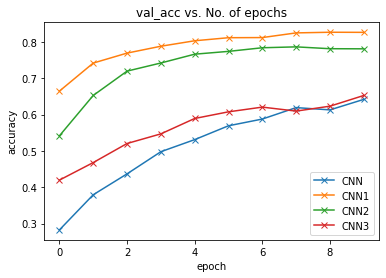

In [35]:
plot_metric(history_cnn)
plot_metric(history_cnn1)
plot_metric(history_cnn2)
plot_metric(history_cnn3)
plt.legend(["CNN","CNN1","CNN2","CNN3"])
plt.show()

Train loss vs. epochs

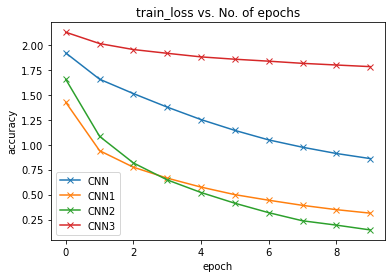

In [36]:
plot_metric(history_cnn,'train_loss')
plot_metric(history_cnn1,'train_loss')
plot_metric(history_cnn2,'train_loss')
plot_metric(history_cnn3,'train_loss')
plt.legend(["CNN","CNN1","CNN2","CNN3"])
plt.show()

Validation loss vs. epochs

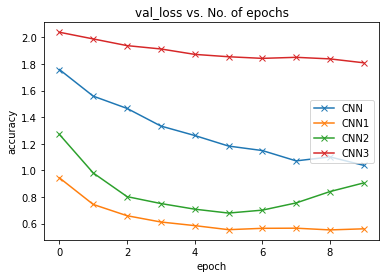

In [37]:
plot_metric(history_cnn,'val_loss')
plot_metric(history_cnn1,'val_loss')
plot_metric(history_cnn2,'val_loss')
plot_metric(history_cnn3,'val_loss')
plt.legend(["CNN","CNN1","CNN2","CNN3"])
plt.show()

Comparison between train loss and validation loss

In [38]:
def plot_loss(history):
    train_loss = [x['train_loss'] for x in history]
    val_loss = [x['val_loss'] for x in history]
    plt.figure("loss correlation")
    plt.plot(train_loss,val_loss, '-x')
    plt.xlabel('train loss')
    plt.ylabel('validation loss')
    plt.title('train loss vs validation loss')

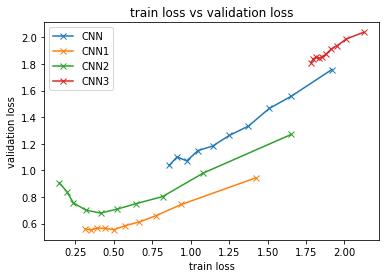

In [39]:
plot_loss(history_cnn)
plot_loss(history_cnn1)
plot_loss(history_cnn2)
plot_loss(history_cnn3)
plt.legend(["CNN","CNN1","CNN2","CNN3"])
plt.show()

Finally test accuracy for each architecture

In [66]:
eval(model_cnn,testloader)
eval(model_cnn1,testloader)
eval(model_cnn2,testloader)
eval(model_cnn3,testloader)

Accuracy of the CNN model on the 10000 test images: 64.03999999999999 %
Accuracy of the CNN1 model on the 10000 test images: 78.06 %
Accuracy of the CNN2 model on the 10000 test images: 78.59 %
Accuracy of the CNN3 model on the 10000 test images: 65.13 %


#### Confusion matrix for each architecture

In [52]:
def conf_matrix(model : nn.Module, test_loader):
    from sklearn.metrics import confusion_matrix
    from seaborn import heatmap
    
    #generate model predictions
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs,labels in test_loader:
            prediction = model(inputs)
            prediction = (torch.max(prediction.data,1))[1]
            y_pred.extend(prediction)
            y_true.extend(labels)
    
    cf_matrix = confusion_matrix(y_true,y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    heatmap(cf_matrix/1000,annot=True,xticklabels=classes,yticklabels=classes,ax=ax,square=True)
    ax.set_title(f"Confusion matrix for {str(type(model))[17:-2]} architecture on cifar-10")
    plt.show()
    return cf_matrix


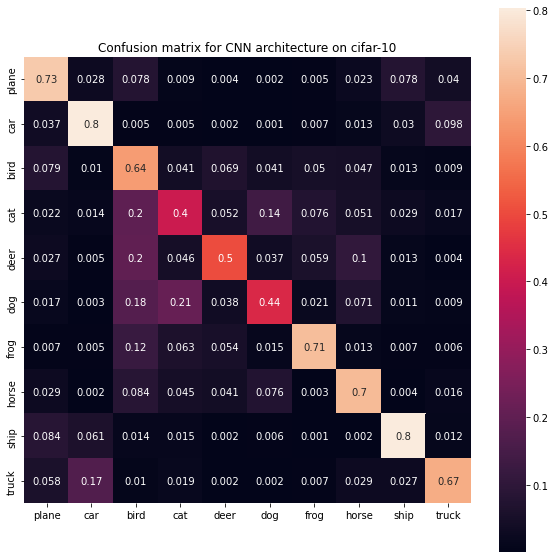

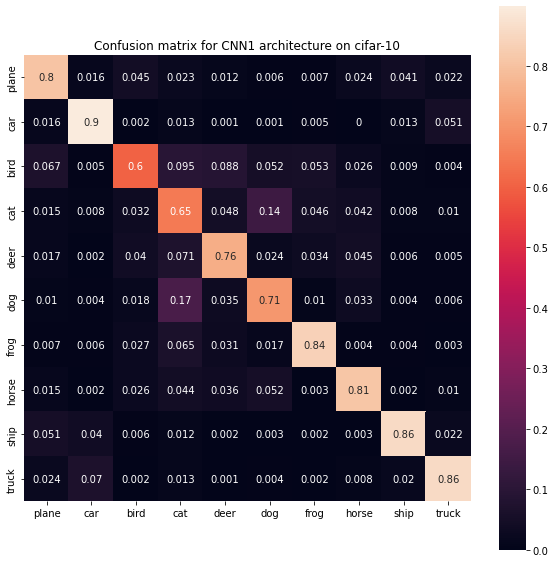

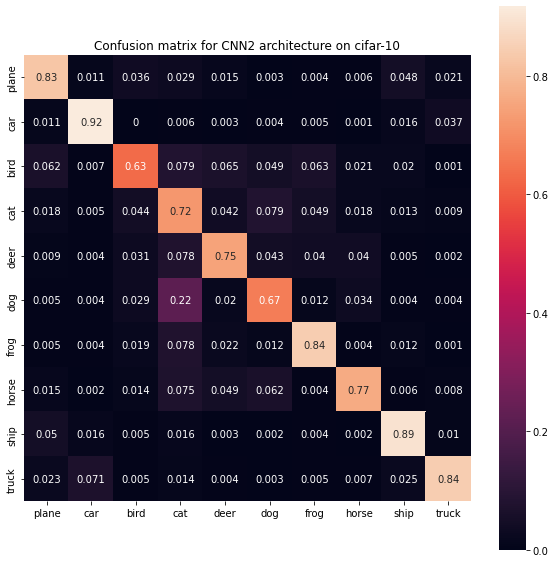

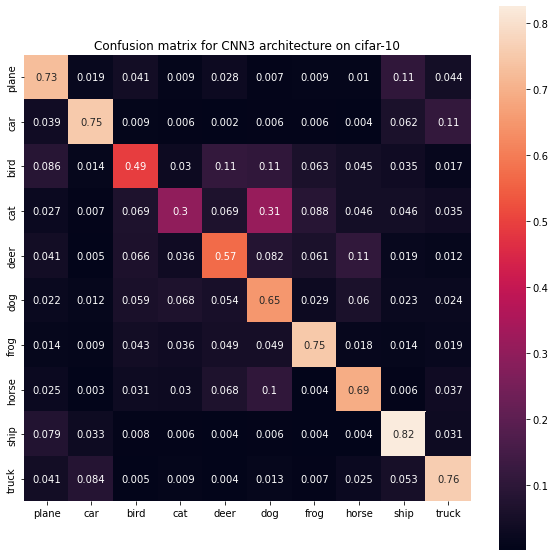

In [53]:
cfm_cnn = conf_matrix(model_cnn,testloader)
cfm_cnn1 = conf_matrix(model_cnn1,testloader)
cfm_cnn2 = conf_matrix(model_cnn2,testloader)
cfm_cnn3 = conf_matrix(model_cnn3,testloader)

### Recurrent Neural Network

In [69]:
class RNN(nn.Module):
    def __init__(self,hidden_dim,layer_dim,dropout = 0) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(32*32*3,hidden_dim,layer_dim,nonlinearity='relu',dropout=dropout,batch_first = True)
        self.fc = nn.Linear(hidden_dim,10)
    
    def forward(self,x):
        x = x.reshape(x.size(0),-1)
        batch_size = x.size(0)
        x = x.unsqueeze(1)
        
        
        hidden = self.init_hidden(batch_size).to(device)
        

        out, hidden = self.rnn(x, hidden)
        
        
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.layer_dim, batch_size, self.hidden_dim)
        return hidden

#### Training function modification for RNN

In [100]:
@torch.no_grad()
def validation_step_rnn(model: nn.Module, batch,device):
    model.eval()
    images,labels = batch[0].to(device), batch[1].to(device)
    outputs,_ = model(images)
    loss = F.cross_entropy(outputs,labels)
    _, predicted = torch.max(outputs.data,1)
    acc = torch.tensor(torch.sum(predicted == labels).item() / len(predicted))
    return {'val_loss': loss.detach(), 'val_acc' : acc}

def fit_rnn(model : nn.Module,train_loader,test_loader,lr=0.001,beta=(0.9, 0.999),eps=1e-8,epochs = 10,crit_class = nn.CrossEntropyLoss,opt_class =optim.Adam ):
    criterion = crit_class()
    optimizer = opt_class(model.parameters(),lr=lr,betas=beta,eps=eps)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    history =[]
    for epoch in range(epochs):
        model.train()
        train_losses =[]

        #training phase
        for i,data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs,_ = model(inputs)
            loss = criterion(outputs,labels)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #validation phase
        outputs = [validation_step_rnn(model,batch,device) for batch in test_loader]
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        train_loss = torch.stack(train_losses).mean()
        results = {'val_loss': epoch_loss.item(),'val_acc':epoch_acc.item(), 'train_loss': train_loss.item()}
        print(f"Model[lr={lr},beta={beta},eps={eps}]Epoch [{epoch}], train_loss: {results['train_loss']:.4f}, val_loss: {results['val_loss']:.4f}, val_acc: {results['val_acc']:.4f}")
        history.append(results)
    print("Finished model training")
    return history


#### Training RNN models with different hidden layer dimensions and sizes

Actual training is done beforehand and the best model will be saved in the ``./best_models`` folder.

In [70]:
rnn_params = [
    (16,1),
    (16,2),
    (16,4),
    (64,1),
    (64,2),
    (64,4),
    (128,1),
    (128,2),
    (128,4),
    (256,1),
    (256,2),
    (256,4),
]

In [ ]:
for hid_dim,layer_dim in rnn_params:
    model_rnn = RNN(hid_dim,layer_dim)
    history_rnn = fit_rnn(model_rnn,trainloader,testloader)
    PATH = f'./RNN_models/hid-dim={hid_dim}_layer-dim={layer_dim}.pth'
    torch.save(model_rnn.state_dict(),PATH)
    PATH = f'./RNN_histories/hid-dim={hid_dim}_layer-dim={layer_dim}.pth'
    torch.save(history_rnn,PATH)

Saving the best RNN model

In [93]:
histories = {}
arch_name = 'RNN'
directory = f'./{arch_name}_histories/'
for filename in os.listdir(directory):
    PATH = directory+filename
    histories[filename] = torch.load(PATH)
best_model_history = max(histories,key = lambda x : histories[x][9]['val_acc'])
print(best_model_history)
model = RNN(256,2)
model.load_state_dict(torch.load(f'./{arch_name}_models/'+best_model_history+'h'))

PATH = './best_models/'+arch_name+'.pth'
torch.save(model.state_dict(),PATH)
PATH = './best_models/'+arch_name+'_history.pt'
torch.save(histories[best_model_history],PATH)

hid-dim=256_layer-dim=2.pt


#### Accuracy and confusion matrix for the best RNN


Firstly, we have to load the model and modify

In [108]:
best_rnn = RNN(256,2)
best_rnn.load_state_dict(torch.load('./best_models/RNN.pth'))
best_rnn.to(device)
best_rnn_history = torch.load('./best_models/RNN_history.pt')


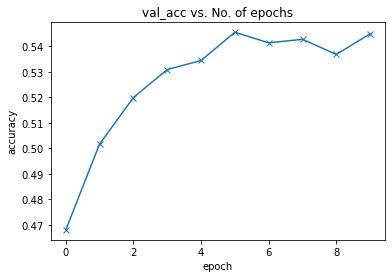

In [109]:
plot_metric(best_rnn_history)

Modified version to generate confusion matrix for RNN

In [110]:
def conf_matrix_rnn(model : nn.Module, test_loader):
    from sklearn.metrics import confusion_matrix
    from seaborn import heatmap
    
    #generate model predictions
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs,labels in test_loader:
            inputs = inputs.to(device)
            predictions,_ = model(inputs)
            _, predictions = torch.max(predictions.data,1)
            y_pred.extend(predictions.data.tolist())
            y_true.extend(labels.tolist())

            
    cf_matrix = confusion_matrix(y_true,y_pred)
    fig, ax = plt.subplots(figsize=(10,10))
    heatmap(cf_matrix/1000,annot=True,xticklabels=classes,yticklabels=classes,ax=ax,square=True)
    ax.set_title(f"Confusion matrix for {str(type(model))[17:-2]} architecture on cifar-10")
    plt.show()
    return cf_matrix

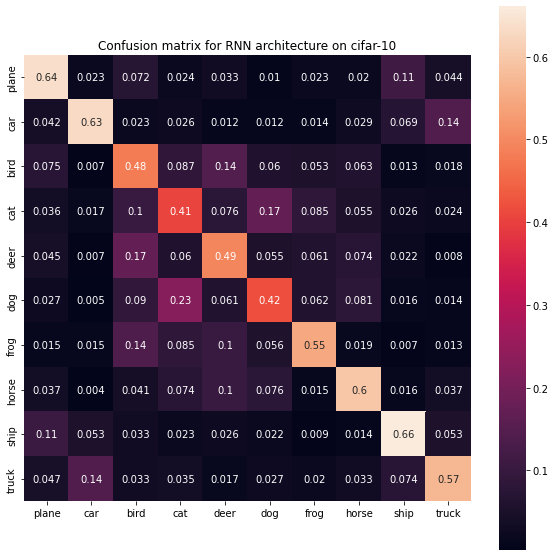

array([[638,  23,  72,  24,  33,  10,  23,  20, 113,  44],
       [ 42, 632,  23,  26,  12,  12,  14,  29,  69, 141],
       [ 75,   7, 480,  87, 144,  60,  53,  63,  13,  18],
       [ 36,  17, 102, 406,  76, 173,  85,  55,  26,  24],
       [ 45,   7, 173,  60, 495,  55,  61,  74,  22,   8],
       [ 27,   5,  90, 226,  61, 418,  62,  81,  16,  14],
       [ 15,  15, 139,  85, 104,  56, 547,  19,   7,  13],
       [ 37,   4,  41,  74, 102,  76,  15, 598,  16,  37],
       [106,  53,  33,  23,  26,  22,   9,  14, 661,  53],
       [ 47, 142,  33,  35,  17,  27,  20,  33,  74, 572]], dtype=int64)

In [111]:
conf_matrix_rnn(best_rnn,testloader)

## TODO

* <s>Create func for class_acc</s>
* Create test for diferent batch_sizes  
* <s>Test CNN2</s>
* <s>Less training parameters, so you dont actually train 1000+ models for each CNN </s>
* <s>Create other CNNs</s>  
* <s>Create RNN</s>
* <s>Test RNN</s>
* Test other CNNs  
* modify .gitignore  
* do better data exploration  
* do better result visualisation  
* do conclusions  
* add sources  

In [168]:
#save the CNN
# PATH = './CNN_test_relu.pth'
PATH = './CNN2_acc_78.pth'
torch.save(model.state_dict(), PATH)

In [112]:
#load the CNN
# PATH = './CNN_test_relu.pth'
# PATH = './CNN_test_sigmoid.pth'
PATH = './CNN_test_kaggle_sequential.pth'
net = CNN1()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [91]:
# eval acc for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class {classname} is {accuracy}")

Accuracy for class plane is 79.1
Accuracy for class car is 87.3
Accuracy for class bird is 51.2
Accuracy for class cat is 38.2
Accuracy for class deer is 55.6
Accuracy for class dog is 49.0
Accuracy for class frog is 81.2
Accuracy for class horse is 69.6
Accuracy for class ship is 74.2
Accuracy for class truck is 57.4
